## Cell type deconvoluation NPC1 --> NPC2

### Key APIs
- expDeconv

### I. Cell type deconvoluation
Translate cell types from single cell reference to ST data (full-rank cluster mode)
- In addition to shared genes, `TransDeconv` requires single cell type lables and per-cell annotations as input;
- After fitting the translation function, `TransDeconv` will output the predictions as well as the weights for each cell type
```python3
preds, weight = expDeconv(
            df_ref=df_ref, 
            df_tgt=df_tgt,
            classes=classes,
            n_epochs=8000,
            lr=1e-2,
            tau=0.1,
            ct_list=ct_list,
            seed=seed,
            device=device
            ) 
```

In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
from transpa.util import expVeloImp, leiden_cluster, expDeconv
import torch
import warnings 

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# load preprocessed scRNA-seq and spatial datasets
NPC1_PATH = '../../../../Downloads/NPC1.h5ad'
NPC2_PATH = '../../../../Downloads/NPC2.h5ad'
NPC1 = sc.read_h5ad(NPC1_PATH)
NPC2 = sc.read_h5ad(NPC2_PATH)
NPC1, NPC2

(AnnData object with n_obs × n_vars = 1331 × 36601
     obs: 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'in_tissue', 'pxl_row_in_fullres_old', 'pxl_col_in_fullres_old', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', '_indices', '_scvi_batch', '_scvi_labels', 'total RNA counts', 'B', 'Myeloid', 'T', 'Treg', 'fibroblast', 'normal', 'tumor', 'Celltype'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1089 × 36601
     obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_coun

The following code prepares input for expDeconv, it
- filters SC types with less than 2 samples, 
- select top cell-type marker genes as training candidate,
- align training & testing genes
- prepare cell cluster labels and annotations


In [2]:
NPC2 = NPC2[:, (NPC2.X.sum(axis=0) > 0)].copy()
NPC1 = NPC1[:, (NPC1.X.sum(axis=0) > 0 )].copy()

sc.pp.highly_variable_genes(NPC2, n_top_genes=5000,  flavor='seurat_v3')
NPC2 = NPC2[:, NPC2.var.highly_variable].copy()

sc.pp.highly_variable_genes(NPC1, n_top_genes=5000,  flavor='seurat_v3')
NPC1 = NPC1[:, NPC1.var.highly_variable].copy()

shared_genes = np.intersect1d(NPC2.var_names, NPC1.var_names)
HybISS = NPC2[:, shared_genes]
NPC1 = NPC1[:, shared_genes]

In [3]:
topk = 50
sc.pp.pca(HybISS, n_comps=30)
celltype_counts = NPC1.obs['Celltype'].value_counts()

celltype_drop = celltype_counts.index[celltype_counts < 2]
ref_adata = NPC1.copy()
if len(celltype_drop):
    print(f'Drop celltype {list(celltype_drop)} (contain less 2 samples)')
    ref_adata = NPC1[~NPC1.obs['Celltype'].isin(celltype_drop),].copy()
    
ref_adata.layers['raw'] = ref_adata.X.copy()


sc.pp.normalize_total(ref_adata)
sc.pp.log1p(ref_adata)


sc.tl.rank_genes_groups(ref_adata, groupby="Celltype", use_raw=False, method='wilcoxon')

ref_adata.X = ref_adata.layers['raw'].copy()
markers_df = pd.DataFrame(ref_adata.uns["rank_genes_groups"]["names"]).iloc[0:topk, :]

genes_sc = np.unique(markers_df.melt().value.values)

gene = np.intersect1d(genes_sc, NPC2.var_names)
ref_adata = ref_adata[:, gene].copy()
tgt_adata = NPC2[:, gene].copy()

df_ref = pd.DataFrame(ref_adata.X.toarray(), columns=ref_adata.var_names)
df_tgt = pd.DataFrame(tgt_adata.X.toarray(), columns=tgt_adata.var_names)

shared_gene = np.intersect1d(df_ref.columns, df_tgt.columns)
df_ref = df_ref[shared_gene]
df_tgt = df_tgt[shared_gene]

classes = ref_adata.obs.Celltype.values
ct_list = np.unique(classes)

candidate_genes = np.unique(markers_df.melt().value.values)
df_mask = pd.DataFrame(np.zeros((len(ct_list), candidate_genes.shape[0]), bool), columns=candidate_genes, index=ct_list)
for ct in ct_list:
    df_mask.loc[ct, df_mask.columns.isin(ref_adata.uns["rank_genes_groups"]['names'][ct][:topk])] = True



- Run the main cell type deconvoluation method
- Normalize result and select the top1 cell type


In [4]:
_, weight = expDeconv(
            df_ref=df_ref / df_ref.sum(axis=1).values.reshape(-1, 1), 
            df_tgt=df_tgt / df_tgt.sum(axis=1).values.reshape(-1, 1),
            classes=classes,
            n_epochs=8000,
            lr=1e-2,
            tau=1.0, # softmax temperature for mapping matrix, < 1.0 to be less even, None to turn-off softmax normalization, recover old transdeconv
            ct_list=ct_list,
            seed=seed,
            device=device
            ) 
df_results = pd.DataFrame(weight, columns=df_mask.index)

df_results = (df_results.T/df_results.sum(axis=1)).T

NPC2.obs['Class'] = df_results.columns[np.argmax(df_results.values, axis=1)]

[LinTrans] Epoch: 8000/8000, loss: 0.667408: 100%|██████████| 8000/8000 [01:10<00:00, 112.85it/s]


#### Plot the deconvolution result

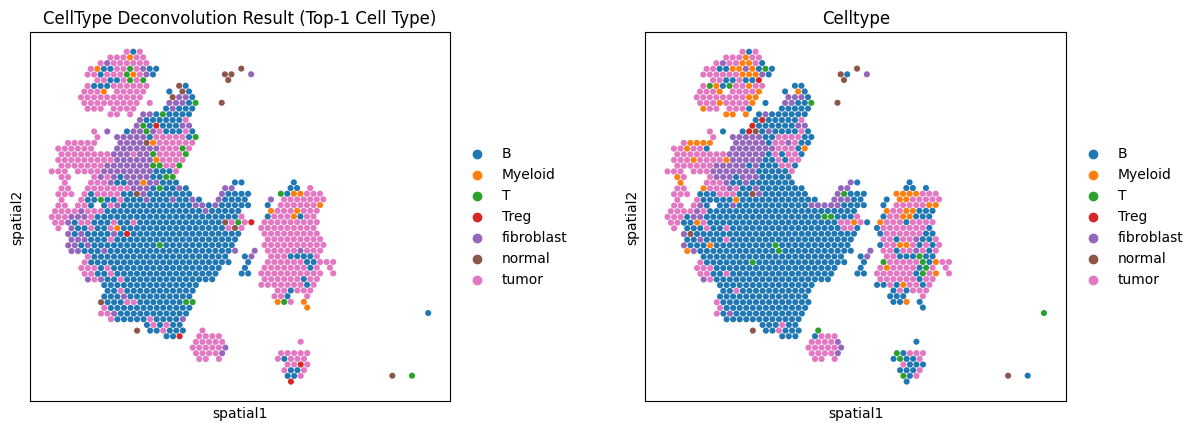

In [5]:
NPC2.obsm['spatial'] = NPC2.obsm['spatial'] * np.array([[1, -1]])
sc.pl.spatial(NPC2, color=['Class', "Celltype"],img_key=None, title="CellType Deconvolution Result (Top-1 Cell Type)", spot_size=200.0)

#### Plot the deconvolution result (Old Result for reference)

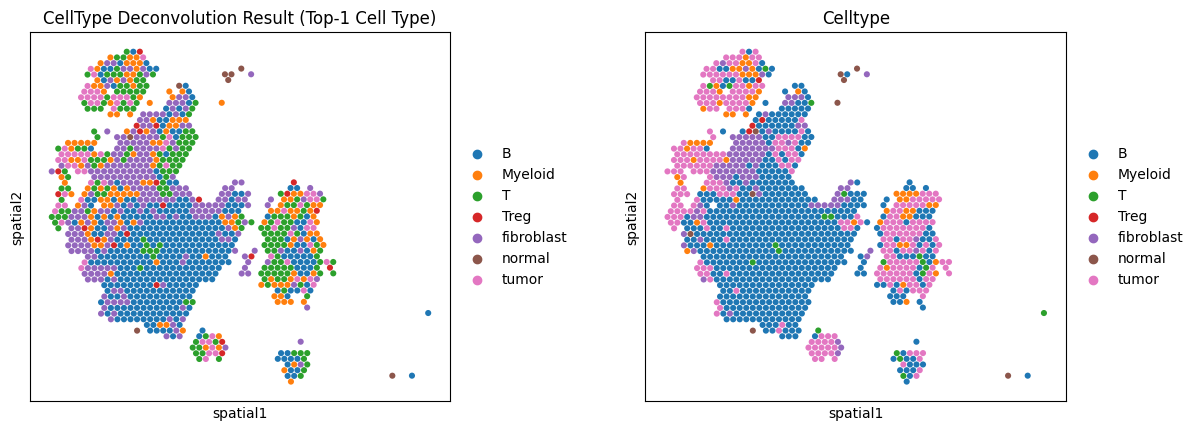

In [ ]:
HybISS.obsm['spatial'] = HybISS.obsm['spatial'] * np.array([[1, -1]])
sc.pl.spatial(HybISS, color=['Class', "Celltype"],img_key=None, title="CellType Deconvolution Result (Top-1 Cell Type)", spot_size=200.0)